<a href="https://colab.research.google.com/github/HYLee810/projectmanager/blob/main/KLUE_BERT_%EB%AC%B8%EC%84%9C_%EB%B6%84%EB%A5%98(%EC%9D%B4%ED%98%84%EC%98%81_%ED%8A%B9%ED%97%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [33]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

from transformers import AutoModelForSequenceClassification
seq_model = AutoModelForSequenceClassification.from_pretrained(
    "klue/bert-base", num_labels=4,  # [TODO] 레이블 종류의 개수를 설정
    id2label={
        0: '(제조)방법', 1: '조성물', 2: '나노패턴(구조)', 3: '나노입자'})  # [TODO] 레이블 번호별 설명
seq_model.to('cuda:0')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

데이터

In [36]:
import pandas as pd
df = pd.read_excel('./sample_data/patent_나노구조 - label.xlsx') # [TODO] 자신의 파일을 불러오기
df.head()

,Unnamed: 0,title,label,abstract
0,0,저밀도 글라스 버블 미세 입자의 기능성 코팅을 위한 원자층 증착기 및 이를 이용한 ...,3,본 발명은 저밀도 글라스 버블 미세 입자의 기능성 코팅을 위한 원자층 증착기 및 이...
1,1,"글라스 코팅 조성물 및 그 코팅 유리 제조 방법과, 이를 이용한 조리기기 (GLAS...",1,가시광 영역에서 80% 이상의 광 투과도를 확보할 수 있음과 더불어 나노분말의 첨가...
2,2,글라스-코팅 미세와이어를 이용한 비구형/비대칭 미립자의 제조방법 (Method fo...,0,본 개시 내용에서는 마이크로/나노입자 제조 기술(NT) 및 레이저 가공 기술을 융합...
3,3,높은 단열성과 접착성을 지닌 에어로겔 코팅액 및 이를 코팅처리한 내열성 글라스울과 ...,0,본 발명은 에어로겔의 취성과 소수성을 강화시키고 단열성과 접착성을 향상시킨 에어로겔...
4,4,에어로겔 코팅액 및 이를 코팅처리한 글라스울 시트 제조방법 (Airgel coati...,0,본 발명은 유기혼합물에 첨가되는 에어로겔의 투입함량을 증가시켜 높은 단열성을 갖도록...


In [44]:
from datasets import Dataset

# [TODO]
# 자신의 데이터에서 사용할 컬럼을 선택(예: title)
# 데이터에 맞춰서 row.document -> row.title
def gen():
    for row in df.itertuples():
        yield {'text': row.abstract, 'label': row.label}

ds = Dataset.from_generator(gen)

Generating train split: 0 examples [00:00, ? examples/s]

In [38]:
ds[0]

{'text': '저밀도 글라스 버블 미세 입자의 기능성 코팅을 위한 원자층 증착기 및 이를 이용한 코팅방법 (Fluidized atomic layer deposition for functional coating of low density glass bubble microparticles and coating method using thereof)',
 'label': 3}

전처리

In [45]:
def convert_example(example):
    result = tokenizer(example['text'])
    result['label'] = [example['label']]
    return result

train_dataset = ds.map(convert_example)

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


훈련

In [47]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=1,
    evaluation_strategy="epoch")

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=seq_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    data_collator=data_collator
)

trainer.train()

Epoch,Training Loss,Validation Loss


RuntimeError: ignored

저장

In [48]:
model_path = 'kogpt2-nsmc'
seq_model.save_pretrained(model_path)

사용

In [49]:
from transformers import pipeline
text_cls = pipeline('text-classification', model=seq_model,
              tokenizer=tokenizer, device='cuda:0')

In [58]:
text_cls('''[청구항1]
광 경화형 바인더 10.0∼50.0 중량%;
광을 흡수하여 라디칼을 형성시킬 수 있는 화합물 0.5∼5.0 중량%;
열전이 특성을 갖는 이산화바나듐 나노입자를 포함하는 이산화바나듐 나노입자 분산액 1.0∼30.0 중량%;
불소계 아다만탄 화합물 0.5~5.0중량%;
레벨링제 0.1∼5.0 중량%; 및
용제 5.0∼87.9 중량%를 포함하며,
상기 불소계 아다만탄 화합물은 하기 구조식 1로 표시되는 광경화가 가능한 불소계 아다만탄 유도체를 포함하는 것을 특징으로 하는 에너지 절감형 기능성 코팅액 조성물.
[구조식 1]
상기 구조식 1에서 Z1은 하기 구조식 2 또는 구조식 3으로 표시되고,
[구조식 2]
[구조식 3]
상기 구조식 2, 구조식 3에서 R1~R4는 각각 독립의 수소원자, 할로겐 원자를 포함하는 탄소수 1∼20까지의 지방족 탄화수소를 표시하며, n 또는 m 은 0 이상의 정수이고,
상기 구조식 1에서 X1은 하기 구조식 4, 구조식 5 또는 구조식 6으로 표시되며,''')

[{'label': '나노패턴(구조)', 'score': 0.3341379761695862}]

In [54]:
text_cls('''본 발명은 광분해에 의한 자기 정화능을 가지며 초친수 반사방지능을 갖는 기능성 표면의 제조방법에 관한 것으로, 상세하게 본 발명에 따른 기능성 표면의 제조방법은 a) 투명 기재의 일 표면에 구 형상을 갖는 복수개의 비드를 단일 층으로 배열하는 단계; b) 상기 복수개의 비드를 식각하여 각 비드간 일정한 이격 거리를 형성하는 단계; c) 상기 일정 이격 거리를 갖는 복수개의 비드를 에칭 마스크(etching mask)로 상기 기재를 식각하여 상기 기재의 일 표면에 표면요철을 형성하는 단계; d) 상기 기재의 일 표면에서 상기 복수개의 비드를 제거하는 단계; 및 e) 상기 표면요철이 형성된 기재의 일 표면에 광촉매 층을 형성하는 단계;를 포함하여 수행되는 특징이 있다..''')

[{'label': '나노패턴(구조)', 'score': 0.4827725291252136}]

In [57]:
text_cls('친수콜로이드 물질 및 천연검류 혼합물을 초고압 전이 동결 후 건조시켜 제조된 나노기공입자를 가진 매트릭스 구조물의 제조방법..')

[{'label': '(제조)방법', 'score': 0.3700561225414276}]

In [4]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=5b7f67aba704fa88ca3c5187a84bfa054292665d996b5111789cfe8188a91b3e
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [6]:
import pandas as pd

In [9]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [11]:
!pip install wordcloud

In [17]:
from wordcloud import WordCloud

In [18]:
wc = WordCloud(
font_path='./sample_data/NanumGothic.ttf', # 글꼴 파일이 있을 경우
background_color='white', # 배경색
max_words=100, # 시각화할 단어 개수
width=400, # 가로 크기
height=300)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=500, stop_words='english')

In [20]:
def extract_nouns(text):
  result = kiwi.tokenize(text)
  for token in result:
    if token.tag in ['NNG', 'NNP']:
      yield token.form

In [15]:
dtm = cv.fit_transform(df['abstract'])
dtm.shape
cv.get_feature_names_out()

array(['001', '01', '10', '100', '12', '13', '15', '1종이상이', '20', '200',
       '30', '31', '3d', '3전극', '3차원', 'acid', 'aicd', 'al2o3', 'alumina',
       'anhydrous', 'b2o3', 'bi2o3', 'bismuthous', 'boric', 'ce2o',
       'cerium', 'c를', 'depth', 'gf', 'iv', 'oxide', 'ph', 'rfid', 'si',
       'silica', 'sio', 'sio2', 'vo', 'water', 'zinc', 'zn', 'zno', '가공된',
       '가능한', '가시광선', '가지는', '가지면서', '간단한', '갖는', '갖는다', '같은', '개시된다',
       '것으로', '것으로서', '것을', '것이다', '결합되고', '결합된', '경도', '경우', '고도로',
       '고분자', '고온용', '고투과', '공급된', '공정', '공정을', '공초점', '관한', '광경화형',
       '광투과도', '광학', '광학적', '광학필름', '광학필름을', '구비되는', '구비하고', '구조를', '구조물',
       '구조의', '구조제어제를', '구조화', '구체', '구체적으로', '균열', '균일하게', '그룹', '그를',
       '글라스', '글라스의', '글라스층', '금속', '금속막위에', '금속산화물', '금속은', '금속을', '금속이',
       '기계적', '기공이', '기능성', '기능을', '기술', '기재된다', '기판', '기판에', '기판을',
       '기판의', '기판이', '나노', '나노결정', '나노구조', '나노구조체를', '나노구조화된', '나노금속',
       '나노미터', '나노와이어를', '나노입자', '나노입자가', '나노입자를', '나노입자에', '나노입자

In [21]:
df=pd.read_excel('./sample_data/patent_나노구조.xlsx')

kiwi=Kiwi()
kiwi.add_user_word('나노구조', 'NNG')
cv = CountVectorizer(max_features=100, tokenizer=extract_nouns)
dtm = cv.fit_transform(df['abstract'])
word_count = pd.DataFrame({
	'단어': cv.get_feature_names_out(),
	'빈도': dtm.sum(axis=0).flat
})
word_count.sort_values('빈도', ascending=False).head(20)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,단어,빈도
80,코팅,216
12,나노,126
31,발명,114
89,포함,112
71,제조,101
42,상기,97
8,글라스,90
33,방법,79
90,표면,78
94,형성,77


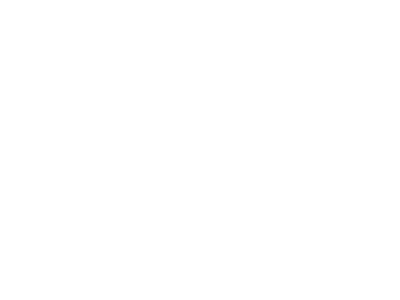

In [26]:
from wordcloud import WordCloud

wc = WordCloud(
    font_path='./sample_data/NanumGothic.ttf', # 원하는 글꼴은 눈누 등의 사이트에서 다운받아 쓰세요
    background_color='white',
    max_words=100,
    width=400,
    height=300
)

count_dic = dict(zip(word_count.단어, word_count.빈도))
cloud =wc.fit_words(count_dic)

cloud.to_image()

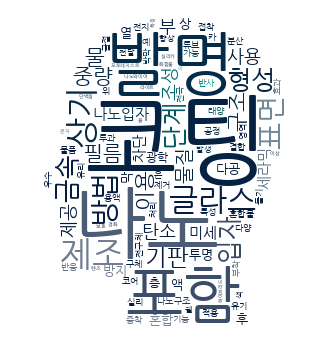

In [28]:
from PIL import Image
import numpy as np

count_dic = dict(zip(word_count.단어, word_count.빈도))
mask = np.asarray(Image.open('./sample_data/AI.png'))

# 그림대로 모양을 잡아준다
wc = WordCloud(background_color='white', font_path='./sample_data/NanumGothic.ttf', mask=mask)
wc.fit_words(count_dic)

# 색칠을 해준다
from wordcloud import ImageColorGenerator
color_func = ImageColorGenerator(mask)
cloud = wc.recolor(color_func=color_func)
cloud.to_image()

In [29]:
df=pd.read_excel('./sample_data/PBL1_dataset.xlsx')

kiwi=Kiwi()
kiwi.add_user_word('나노구조', 'NNG')
cv = CountVectorizer(max_features=100, tokenizer=extract_nouns)
dtm = cv.fit_transform(df['abstract'])
word_count = pd.DataFrame({
	'단어': cv.get_feature_names_out(),
	'빈도': dtm.sum(axis=0).flat
})
word_count.sort_values('빈도', ascending=False).head(20)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,단어,빈도
90,표면,368
79,코팅,262
96,형성,205
27,발명,185
29,방지,183
88,포함,183
53,오염,164
18,렌즈,161
22,물,156
39,상기,151


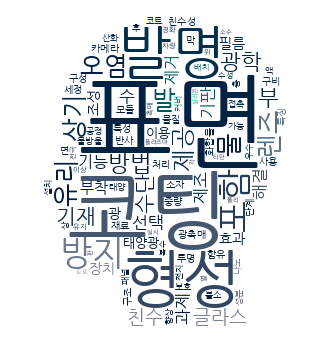

In [30]:
from PIL import Image
import numpy as np

count_dic = dict(zip(word_count.단어, word_count.빈도))
mask = np.asarray(Image.open('./sample_data/AI.png'))

# 그림대로 모양을 잡아준다
wc = WordCloud(background_color='white', font_path='./sample_data/NanumGothic.ttf', mask=mask)
wc.fit_words(count_dic)

# 색칠을 해준다
from wordcloud import ImageColorGenerator
color_func = ImageColorGenerator(mask)
cloud = wc.recolor(color_func=color_func)
cloud.to_image()